<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fclassification/applications/classification/QQP%20Classification%20with%20Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
TASK_DATA_DIR = 'glue_data/QQP'
!test -d glue_data || git clone https://gist.github.com/60c2bdb54d156a41194446737ce03e2e.git glue_data
!test -d $TASK_DATA_DIR || python glue_data/download_glue_data.py --data_dir glue_data --tasks=QQP
!ls -alh $TASK_DATA_DIR

Cloning into 'glue_data'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21
Unpacking objects: 100% (21/21), done.
	Completed!
total 104M
drwxr-xr-x 3 root root 4.0K Jun 12 16:29 .
drwxr-xr-x 4 root root 4.0K Jun 12 16:29 ..
-rw-r--r-- 1 root root 5.6M Jun 12 16:29 dev.tsv
drwxr-xr-x 2 root root 4.0K Jun 12 16:29 original
-rw-r--r-- 1 root root  49M Jun 12 16:29 test.tsv
-rw-r--r-- 1 root root  50M Jun 12 16:29 train.tsv


In [0]:
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from fastai.text import Tokenizer, Vocab
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle


In [0]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
train_df = pd.read_csv(TASK_DATA_DIR + '/train.tsv', sep='\t', error_bad_lines=False)
valid_df = pd.read_csv(TASK_DATA_DIR + '/dev.tsv', sep='\t', error_bad_lines=False)
train_df.head()

b'Skipping line 83032: expected 6 fields, saw 7\n'
b'Skipping line 154657: expected 6 fields, saw 7\n'
b'Skipping line 323916: expected 6 fields, saw 7\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222.0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0.0
1,402555,536040,536041.0,How do I control my horny emotions?,How do you control your horniness?,1.0
2,360472,364011,490273.0,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0.0
3,150662,155721,7256.0,What can one do after MBBS?,What do i do after my MBBS ?,1.0
4,183004,279958,279959.0,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0.0


In [0]:
print(f"Training df shape: {train_df.shape}")
print(f"Validation df shape: {valid_df.shape}")

Training df shape: (363192, 6)
Validation df shape: (40372, 6)


### Simple Data Exploration

Text(0.5, 0, 'Number of duplicate questions in training data')

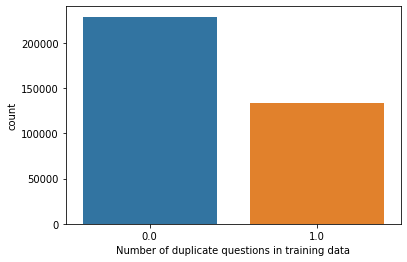

In [0]:
sns.countplot(train_df.is_duplicate)
plt.xlabel('Number of duplicate questions in training data')

Text(0.5, 0, 'Number of duplicate questions in validation data')

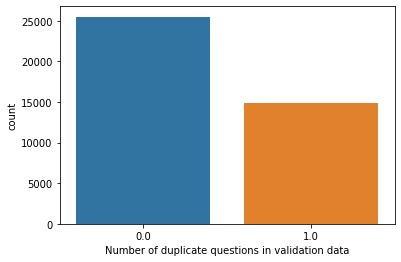

In [0]:
sns.countplot(valid_df.is_duplicate)
plt.xlabel('Number of duplicate questions in validation data')

Remove the unnecessary columns

In [0]:
train_df = train_df.drop(columns=['id', 'qid1', 'qid2'])
valid_df = valid_df.drop(columns=['id', 'qid1', 'qid2'])
train_df.head()

,question1,question2,is_duplicate
0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0.0
1,How do I control my horny emotions?,How do you control your horniness?,1.0
2,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0.0
3,What can one do after MBBS?,What do i do after my MBBS ?,1.0
4,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0.0


In [0]:
print(f"Percentage of Question pairs that are not Similar (is_duplicate = 0): {100 - round(train_df['is_duplicate'].mean()*100, 2)}%")
print(f"Percentage of Question pairs that are Similar (is_duplicate = 1): {round(train_df['is_duplicate'].mean()*100, 2)}%")

Percentage of Question pairs that are not Similar (is_duplicate = 0): 63.06%
Percentage of Question pairs that are Similar (is_duplicate = 1): 36.94%


In [0]:
train_df['q1_length'] = train_df['question1'].apply(lambda x: len(str(x)))
train_df['q2_length'] = train_df['question2'].apply(lambda x: len(str(x)))
train_df.head()

,question1,question2,is_duplicate,q1_length,q2_length
0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0.0,75,55
1,How do I control my horny emotions?,How do you control your horniness?,1.0,35,34
2,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0.0,44,49
3,What can one do after MBBS?,What do i do after my MBBS ?,1.0,27,28
4,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0.0,67,121


In [0]:
train_df.q1_length.mean()

59.622042886407186

In [0]:
train_df.q2_length.mean()

60.173357342672745

In [0]:
train_df = train_df.drop(['q1_length', 'q2_length'], axis=1)
train_df.head()

,question1,question2,is_duplicate
0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0.0
1,How do I control my horny emotions?,How do you control your horniness?,1.0
2,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0.0
3,What can one do after MBBS?,What do i do after my MBBS ?,1.0
4,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0.0


### Processing Data

In [0]:
def tokenizer(texts):
    tokens = Tokenizer().process_all(texts)
    print(f"sentence: {texts[0]}")
    print(f"tokens: {tokens[0]}")
    return tokens

In [0]:
class QQPProcessor:
    def __init__(self, max_vocab, min_freq, tokenizer):
        self.max_vocab = max_vocab
        self.min_freq = min_freq
        self.tokenizer = tokenizer
        self.vocab = None
    
    def tokenize(self, question1, question2):
        all_texts = []
        for q1, q2 in zip(question1, question2):
            all_texts.append(q1)
            all_texts.append(q2)
        start_time = time.time()
        sents_tokens = self.tokenizer(all_texts)
        end_time = time.time()
        print(f"Tokenization took: {end_time - start_time} secs")
        if self.vocab is None:
            print(f"Building vocabulary")
            self.vocab = Vocab.create(sents_tokens, max_vocab=self.max_vocab, min_freq=self.min_freq)
        
        sents_nums = [self.vocab.numericalize(s) for s in sents_tokens]

        question1_seq, question2_seq = [], []
        for i in range(0, len(sents_nums), 2):
            question1_seq.append(sents_nums[i])
            question2_seq.append(sents_nums[i+1])

        return question1_seq, question2_seq


In [0]:
max_vocab = 5000
min_freq = 5

processor = QQPProcessor(max_vocab, min_freq, tokenizer)

In [0]:
train_df = shuffle(train_df)

train_question1 = train_df.question1.values[:50000]
train_question2 = train_df.question2.values[:50000]
train_labels = train_df.is_duplicate.values[:50000]

val_question1 = valid_df.question1.values[:2000]
val_question2 = valid_df.question2.values[:2000]
val_labels = valid_df.is_duplicate.values[:2000]

In [0]:
print(f"Training samples: {len(train_question1)}")
print(f"Validation samples: {len(val_question1)}")

Training samples: 50000
Validation samples: 2000


In [0]:
train_q1_seq, train_q2_seq = processor.tokenize(train_question1, train_question2)

sentence: What is the top speed of bus rapid transit on dedicated lanes?
tokens: ['xxmaj', 'what', 'is', 'the', 'top', 'speed', 'of', 'bus', 'rapid', 'transit', 'on', 'dedicated', 'lanes', '?']
Tokenization took: 13.463430166244507 secs
Building vocabulary


In [0]:
print(train_question1[0])
train_q1_seq[0]

What is the top speed of bus rapid transit on dedicated lanes?


[5, 11, 12, 10, 250, 429, 19, 4090, 0, 3430, 30, 0, 0, 9]

In [0]:
print(train_question2[0])
train_q2_seq[0]

What is the top speed of ZX-6R?


[5, 11, 12, 10, 250, 429, 19, 6, 0, 9]

In [0]:
val_q1_seq, val_q2_seq = processor.tokenize(val_question1, val_question2)

sentence: Why are African-Americans so beautiful?
tokens: ['xxmaj', 'why', 'are', 'xxmaj', 'african', '-', 'xxmaj', 'americans', 'so', 'beautiful', '?']
Tokenization took: 1.2879095077514648 secs


In [0]:
def collate_fn(data):
    def merge(sequences):
        lengths = [len(seq) for seq in sequences]
        padded_seqs = torch.zeros(len(sequences), max(lengths)).long()
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq[:end]
        return padded_seqs, lengths

    data.sort(key=lambda x: len(x[0]), reverse=True)
    q1_seqs, q2_seqs, labels = zip(*data)

    q1_seqs, q1_lengths = merge(q1_seqs)
    q2_seqs, q2_lengths = merge(q2_seqs)
    labels = torch.FloatTensor(labels)
    return q1_seqs.transpose(0, 1), q1_lengths, q2_seqs.transpose(0, 1), q2_lengths, labels

In [0]:
class QuoraDataset(Dataset):
    def __init__(self, question1, question2, is_duplicate):
        self.question1 = question1
        self.question2 = question2
        self.label = is_duplicate

        assert len(question1) == len(question2)
        self.length = len(is_duplicate)
    
    def __getitem__(self, index):
        q1_seq = torch.Tensor(self.question1[index])
        q2_seq = torch.Tensor(self.question2[index])
        label = self.label[index]
        return q1_seq, q2_seq, label

    def __len__(self):
        return self.length

In [0]:
train_dataset = QuoraDataset(train_q1_seq, train_q2_seq, train_labels)
val_dataset = QuoraDataset(val_q1_seq, val_q2_seq, val_labels)

In [0]:
train_dataset[23]

(tensor([   5.,   11.,   42.,   10.,   91.,   66.,   15.,    0.,    6.,    0.,
         1325.,   21.,  500.,   54.,    5., 2535.,   34.,    6.,    0.,    9.]),
 tensor([   5., 2535.,    6.,    0.,    5., 1325.,   88.,    5., 3955., 3356.,
         3613.,    9.]),
 0.0)

In [0]:
BATCH_SIZE = 64

In [0]:
def get_loader(q1_data, q2_data, label_data, train=True, batch_size=BATCH_SIZE):
    dataset = QuoraDataset(q1_data, q2_data, label_data)

    if train:
        shuffle = True
    else:
        shuffle = False
    
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        collate_fn=collate_fn)

    return dataloader

In [0]:
train_loader = get_loader(train_q1_seq, train_q2_seq, train_labels)
val_loader = get_loader(val_q1_seq, val_q2_seq, val_labels, False)

In [0]:
q1_batch, q1_len, q2_batch, q2_len, trg = next(iter(train_loader))

In [77]:
print(q1_batch.shape)
print(len(q1_len))
print(q2_batch.shape)
print(len(q2_len))
print(trg.shape)

torch.Size([48, 64])
64
torch.Size([60, 64])
64
torch.Size([64])


In [0]:
class RNN(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, output_dim, dropout):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, num_layers=num_layers, bidirectional=True)
        self.fc_1 = nn.Linear(hidden_dim * 5, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_3 = nn.Linear(50, output_dim)

        self.dropout = nn.Dropout(dropout)
        self.ln_1 = nn.LayerNorm(hidden_dim)
        self.ln_2 = nn.LayerNorm(50)
        self.bn_1 = nn.BatchNorm1d(hidden_dim)
        self.bn_2 = nn.BatchNorm1d(50)
    
    def forward(self, q1, q1_lengths, q2, q2_lengths):
        # q1 => [q1_seq_len, batch_size]
        # q1_lengths => [batch_size]
        # q2 => [q2_seq_len, batch_size]
        # q2_lengths => [batch_size]

        q1_embed = self.dropout(self.embedding(q1))
        q2_embed = self.dropout(self.embedding(q2))
        # q1_embed => [q1_seq_len, batch_size, emb_dim]
        # q2_embed => [q2_seq_len, batch_size, emb_dim]

        q1_packed = nn.utils.rnn.pack_padded_sequence(q1_embed, q1_lengths)

        _, q1_hidden = self.rnn(q1_packed)
        q1_hidden = q1_hidden.view(self.num_layers, 2, -1, self.hidden_dim)
        # q1_hidden => [num_layers, num_dir, batch_size, hidden_dim]

        q1_final_layer_hidden = q1_hidden[-1, :, :, :]
        # q1_final_layer_hidden => [num_dir, batch_size, hidden_dim]

        q1_representation = q1_final_layer_hidden[0] + q1_final_layer_hidden[1]
        # q1_representation => [batch_size, hidden_dim]

        q1_representation = self.dropout(q1_representation)
        # q1_representation => [batch_size, hidden_dim]

        _, q2_hidden = self.rnn(q2_embed)
        q2_hidden = q2_hidden.view(self.num_layers, 2, -1, self.hidden_dim)
        # q2_hidden => [num_layers, num_dir, batch_size, hidden_dim]

        q2_final_layer_hidden = q2_hidden[-1, :, :, :]
        # q2_final_layer_hidden => [num_dir, batch_size, hidden_dim]

        q2_representation = q2_final_layer_hidden[0] + q2_final_layer_hidden[1]
        # q2_representation => [batch_size, hidden_dim]

        q2_representation = self.dropout(q2_representation)
        # q2_representation => [batch_size, hidden_dim]

        diff = q1_representation - q2_representation
        # diff => [batch_size, hidden_dim]

        add = q1_representation + q2_representation
        # add => [batch_size, hidden_dim]
        
        mul = q1_representation * q2_representation
        # mul => [batch_size, hidden_dim]

        concat = torch.cat((q1_representation, q2_representation), dim=-1)
        # concat => [batch_size, hidden_dim * 2]

        combined = torch.cat((diff, add, mul, concat), dim=-1)
        # combined => [batch_size, hidden_dim * 5]

        combined = self.dropout(combined)
        # combined => [batch_size, hidden_dim * 5]

        out_1 = self.bn_1(self.ln_1(self.dropout(torch.relu(self.fc_1(combined)))))
        # out_1 => [batch_size, hidden_dim]

        out_2 = self.bn_2(self.ln_2(self.dropout(torch.relu(self.fc_2(out_1)))))
        # out_2 => [batch_size, 50]

        logits = self.fc_3(out_2)
        # logits => [batch_size, 1]

        return logits 

In [0]:
input_dim = len(processor.vocab.itos)
emb_dim = 100
hidden_dim = 200
dropout = 0.3
output_dim = 1
num_layers = 2

model = RNN(input_dim, emb_dim, hidden_dim, num_layers, output_dim, dropout)

In [84]:
model.to(device)

RNN(
  (embedding): Embedding(5000, 100)
  (rnn): GRU(100, 200, num_layers=2, bidirectional=True)
  (fc_1): Linear(in_features=1000, out_features=200, bias=True)
  (fc_2): Linear(in_features=200, out_features=50, bias=True)
  (fc_3): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (ln_1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
  (ln_2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
  (bn_1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [0]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
def train(device, model, iterator, criterion, optimizer, clip):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch in iterator:
        optimizer.zero_grad()
        q1, q1_len, q2, q2_len, labels = batch
        q1, q2, labels = q1.to(device), q2.to(device), labels.to(device)
        logits = model(q1, q1_len, q2, q2_len).squeeze()
        # logits => [batch_size]

        loss = criterion(logits, labels)
        train_loss += loss.item()
        acc = binary_accuracy(logits, labels)
        train_acc += acc.item()
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()

    return train_loss / len(iterator), train_acc / len(iterator)

In [0]:
def evaluate(device, model, iterator, criterion):
    model.eval()
    eval_loss = 0
    eval_acc = 0
    with torch.no_grad():
        for batch in iterator:
            q1, q1_len, q2, q2_len, labels = batch
            q1, q2, labels = q1.to(device), q2.to(device), labels.to(device)

            logits = model(q1, q1_len, q2, q2_len).squeeze()
            # logits => [batch_size]

            loss = criterion(logits, labels)
            eval_loss += loss.item()
            acc = binary_accuracy(logits, labels)
            eval_acc += acc.item()

    return eval_loss / len(iterator), eval_acc / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins * 60)
    return elapsed_mins, elapsed_secs

In [0]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(device, model, train_loader, criterion, optimizer, CLIP)
    val_loss, val_acc = evaluate(device, model, val_loader, criterion)
    end_time = time.time()
    elapsed_mins, elapsed_secs = epoch_time(start_time, end_time)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc * 100:.2f} | Time: {elapsed_mins}m {elapsed_secs}s")